<a href="https://colab.research.google.com/github/d-roland/Fake-news-detection/blob/master/CS221_Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from collections import Counter, defaultdict
from wordcloud import WordCloud
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Analyzing BuzzFeed Real News Content** 

In [3]:
bfreal = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_real_news_content.csv')
bfreal.shape

(91, 12)

In [4]:
bfreal.head()

id  ...                                          meta_data
0   Real_1-Webpage  ...  {"description": "\u201cWe believe at this poin...
1  Real_10-Webpage  ...  {"fb_title": "Trump: Drugs a 'Very, Very Big F...
2  Real_11-Webpage  ...  {"googlebot": "noimageindex", "og": {"site_nam...
3  Real_12-Webpage  ...  {"description": "He sees it as zero-sum. She b...
4  Real_13-Webpage  ...  {"fb_title": "President Obama Vetoes 9/11 Vict...

[5 rows x 12 columns]

In [5]:
bfreal.describe()

id  ...                                          meta_data
count                91  ...                                                 91
unique               91  ...                                                 91
top     Real_54-Webpage  ...  {"description": "\u201cI think he\u2019s hijac...
freq                  1  ...                                                  1

[4 rows x 12 columns]

In [6]:
for key,count in bfreal.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bfreal.shape[0]))

http://politi.co:	32
http://cnn.it:	23
http://abcn.ws:	9
http://rightwingnews.com:	7
http://eaglerising.com:	7
http://www.addictinginfo.org:	3
http://www.ifyouonlynews.com:	2
http://addictinginfo.org:	2
http://occupydemocrats.com:	1
http://freedomdaily.com:	1
https://www.washingtonpost.com:	1
http://conservativebyte.com:	1
http://www.opposingviews.com:	1
http://winningdemocrats.com:	1
Total Records:	91


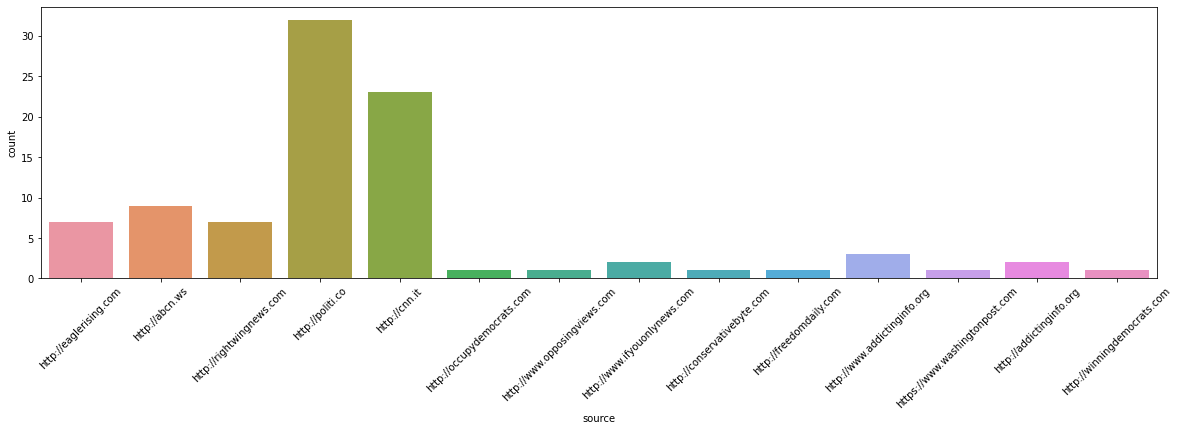

In [7]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bfreal)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

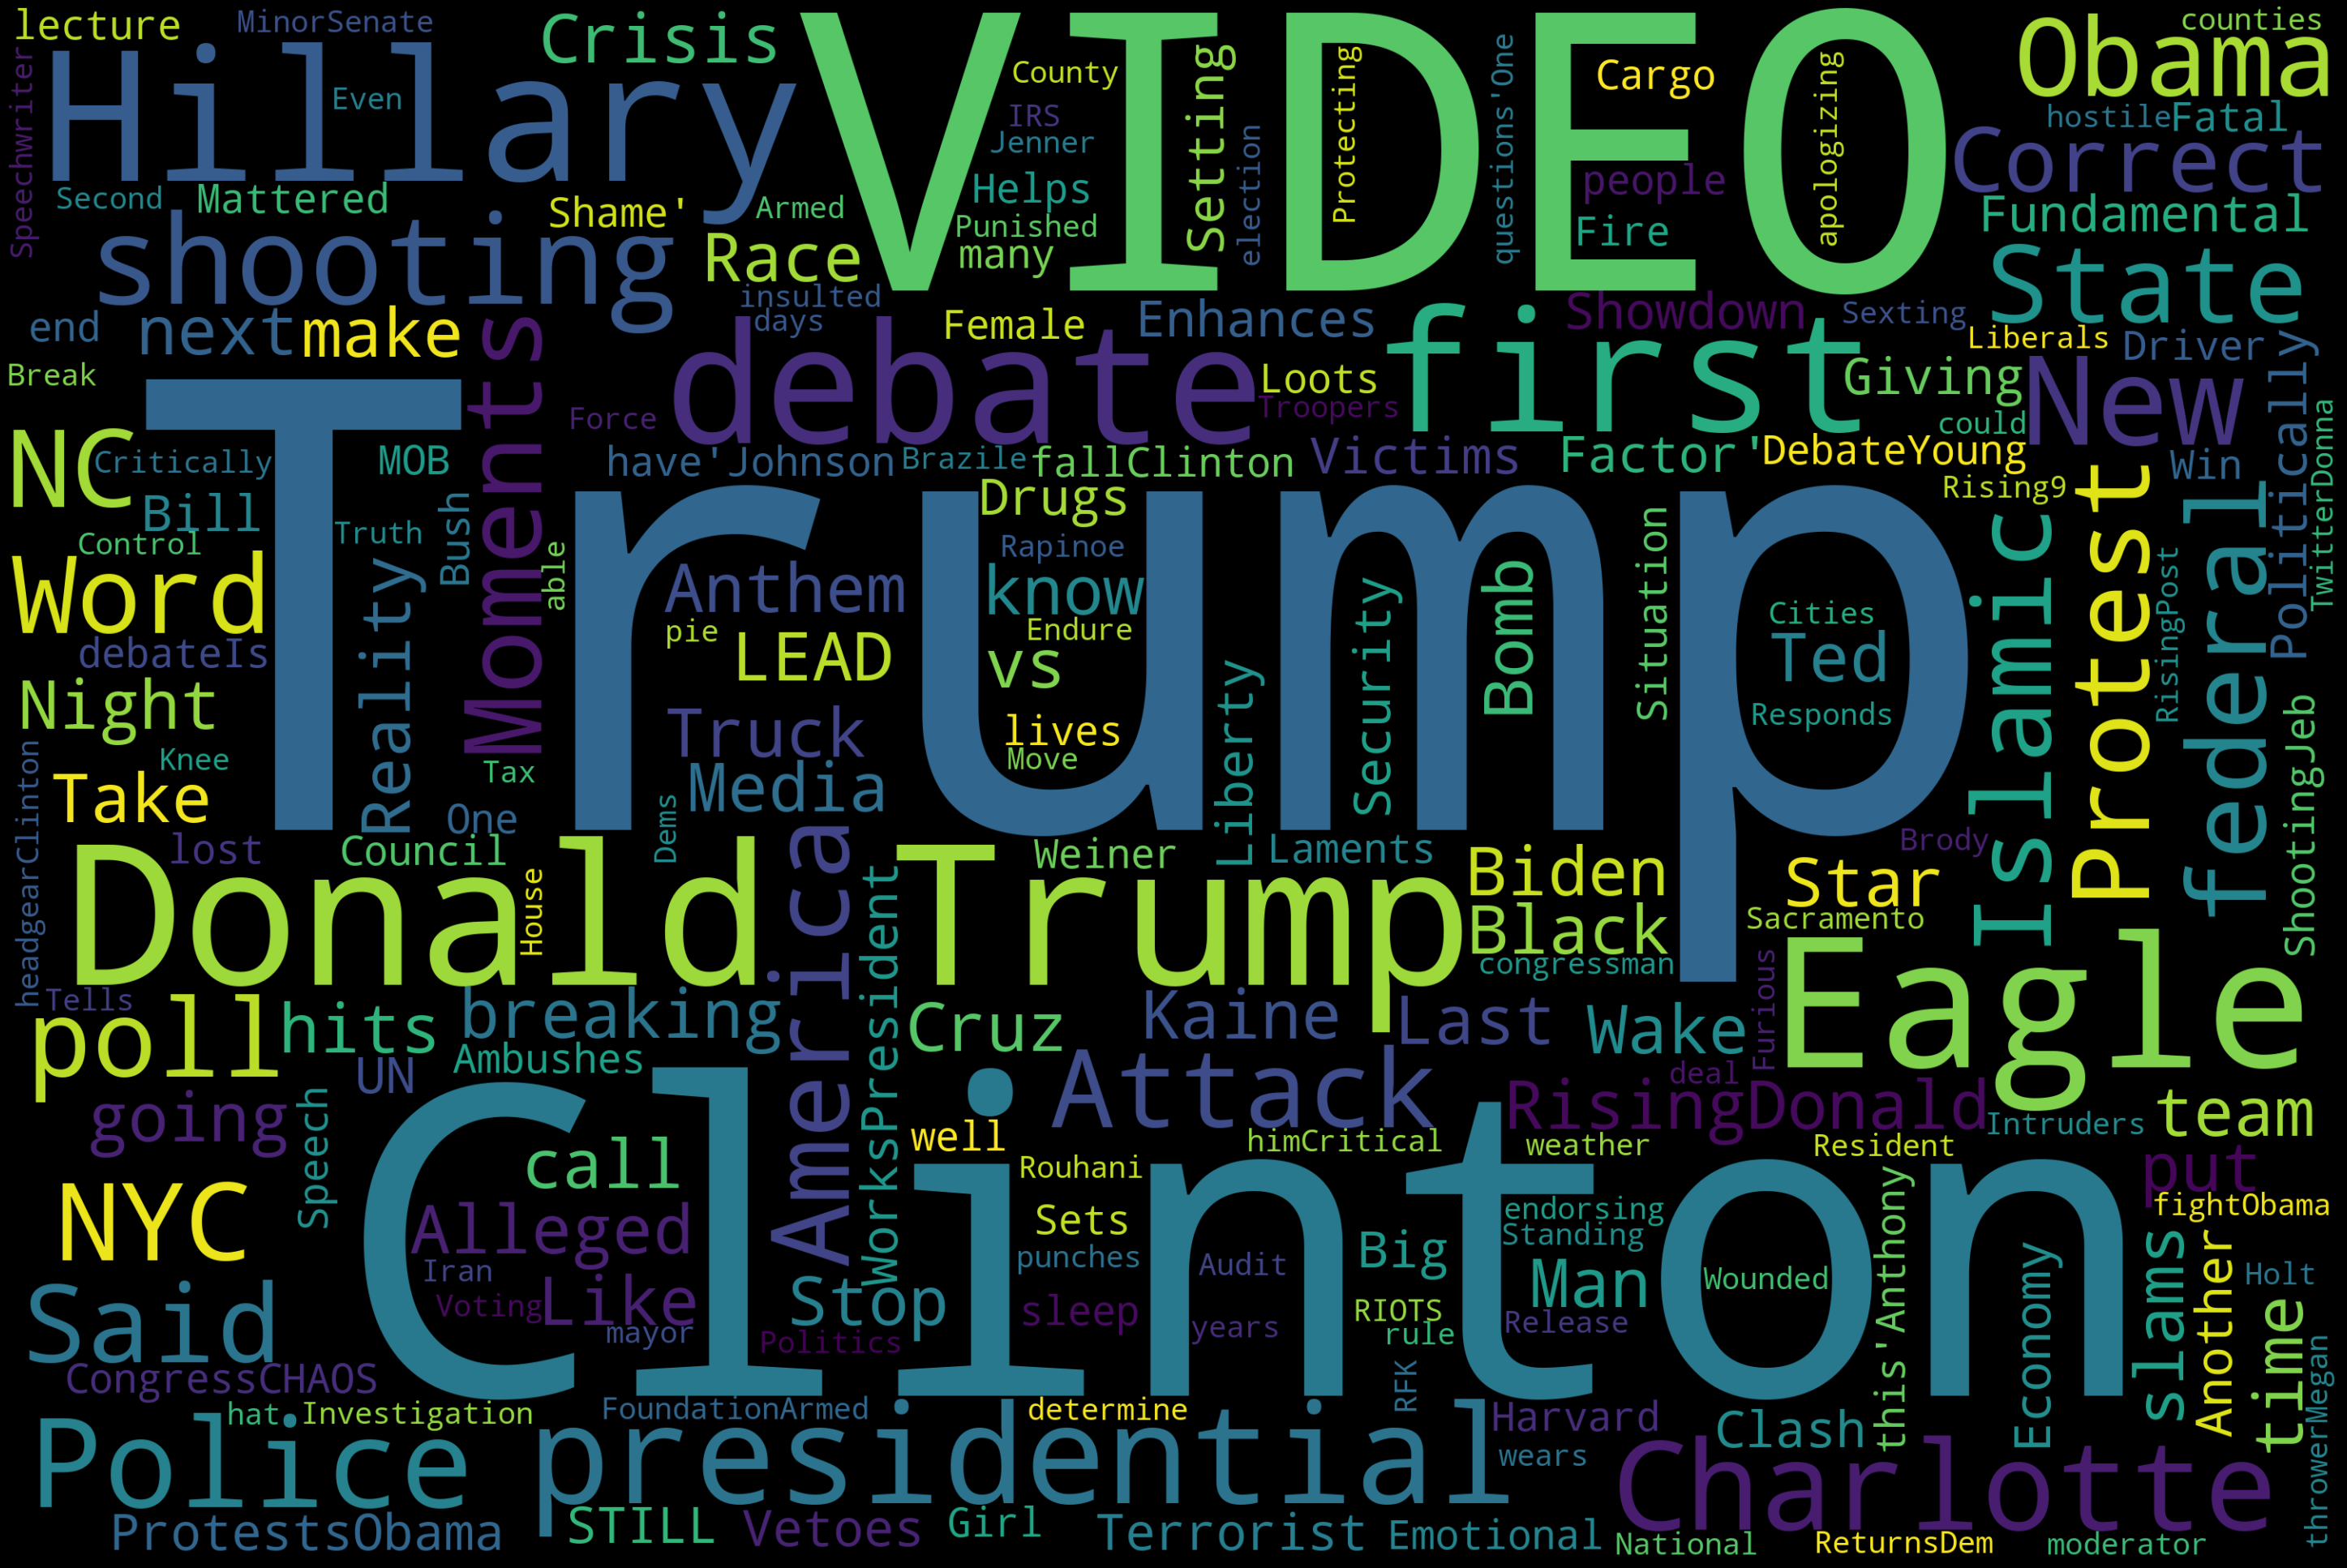

In [8]:
#Word Cloud
text = ''
for news in bfreal.title.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

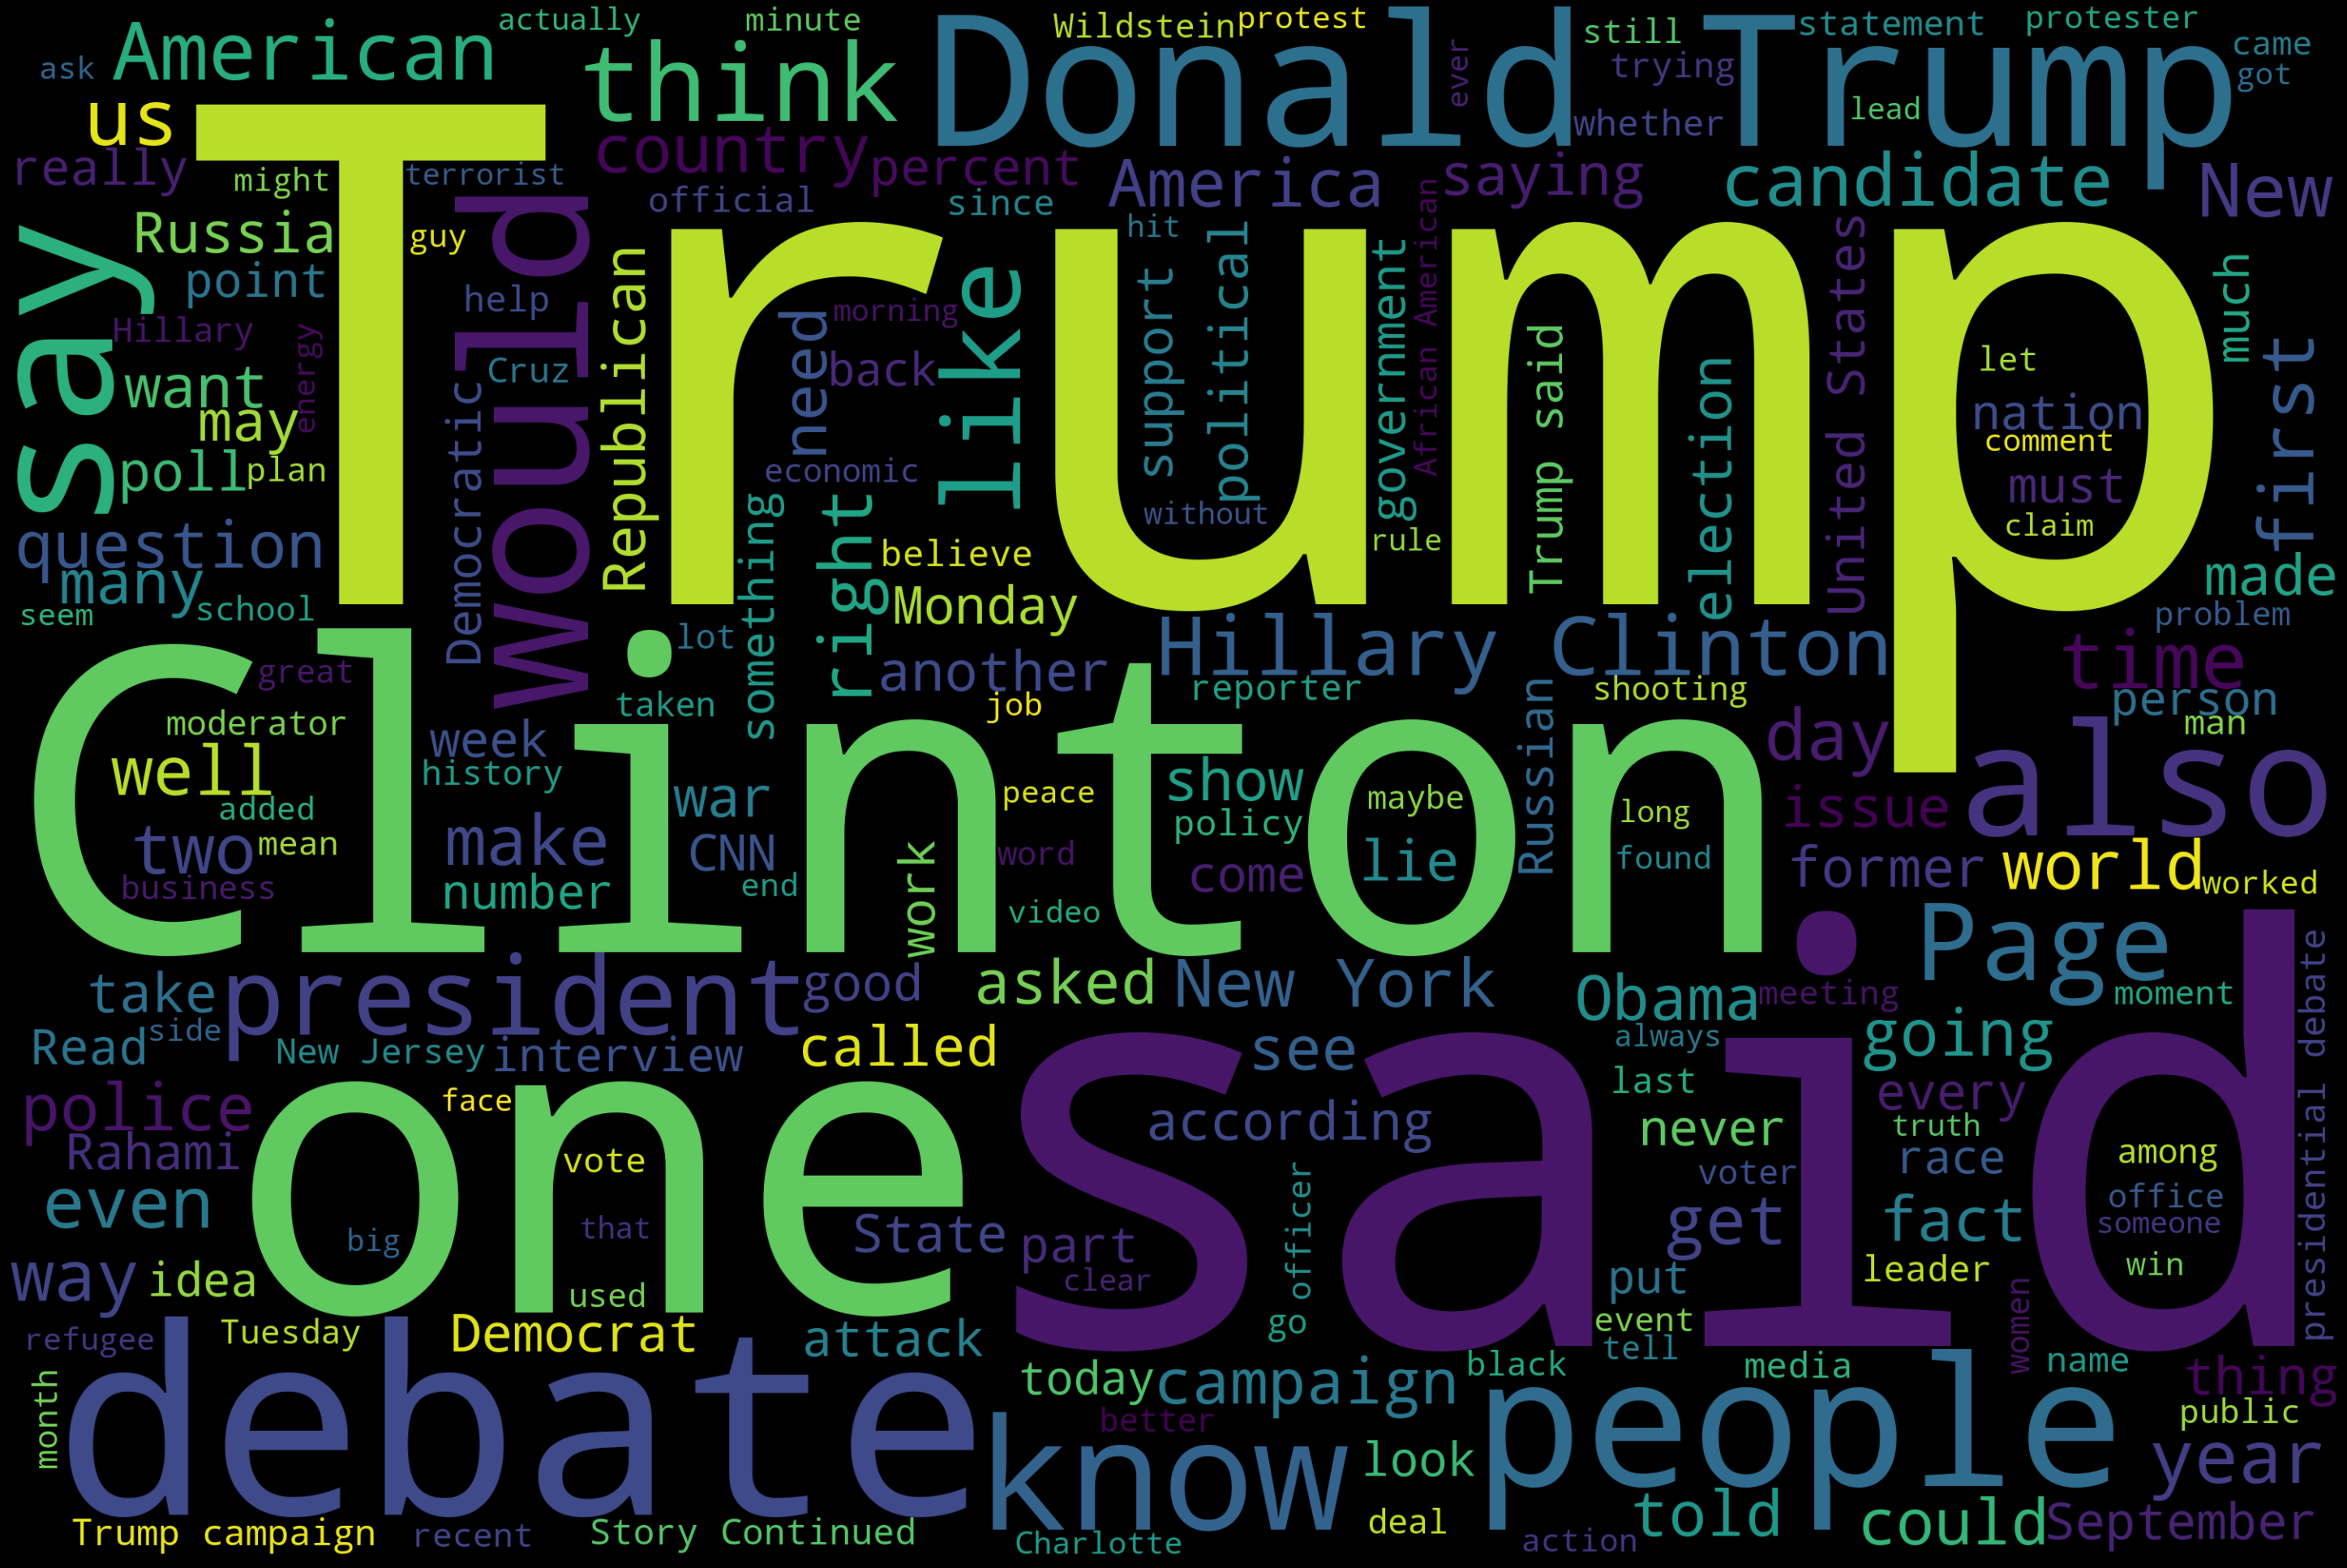

In [9]:
#Word Cloud
text = ''
for news in bfreal.text.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

Adding class indication, and an empty subject column, prior to merging with Fake-and-real-news dataset.

In [10]:
bfreal["class"]=1
bfreal["subject"]=''
bfreal.head()

id  ... subject
0   Real_1-Webpage  ...        
1  Real_10-Webpage  ...        
2  Real_11-Webpage  ...        
3  Real_12-Webpage  ...        
4  Real_13-Webpage  ...        

[5 rows x 14 columns]

Removing all polluting expressions in both text and title

In [0]:
#Seperating Publication info, from actual text
pollution_real = ["⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_real:
    bfreal['title'] = bfreal['title'].str.replace(i , '')
    bfreal['text'] = bfreal['text'].str.replace(i , '')

### **Analyzing BuzzFeed Fake News Content** 

In [12]:
bffake = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_fake_news_content.csv')
bffake.shape

(91, 12)

In [13]:
bffake.head()

id  ...                                          meta_data
0   Fake_1-Webpage  ...  {"publisher": "Addicting Info | The Knowledge ...
1  Fake_10-Webpage  ...  {"description": "The possibility that CHAI dis...
2  Fake_11-Webpage  ...  {"description": "Hillary Clinton may be the fi...
3  Fake_12-Webpage  ...  {"publisher": "Addicting Info | The Knowledge ...
4  Fake_13-Webpage  ...  {"og": {"url": "http://www.proudcons.com", "ty...

[5 rows x 12 columns]

In [14]:
bffake.describe()

id  ... meta_data
count                91  ...        91
unique               91  ...        81
top     Fake_67-Webpage  ...        {}
freq                  1  ...         8

[4 rows x 12 columns]

In [15]:
for key,count in bffake.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bffake.shape[0]))

http://rightwingnews.com:	17
http://freedomdaily.com:	16
http://eaglerising.com:	11
http://occupydemocrats.com:	6
https://goo.gl:	3
http://www.thepoliticalinsider.com:	3
http://www.addictinginfo.org:	3
http://usherald.com:	2
http://allenwestrepublic.com:	2
http://100percentfedup.com:	2
http://winningdemocrats.com:	2
https://ihavethetruth.com:	2
http://conservativetribune.com:	2
http://theblacksphere.net:	2
http://www.proudcons.com:	2
http://clashdaily.com:	2
http://author.addictinginfo.org:	1
http://www.yesimright.com:	1
http://addictinginfo.org:	1
http://www.chicksontheright.com:	1
http://conservativebyte.com:	1
http://author.groopspeak.com:	1
Total Records:	91


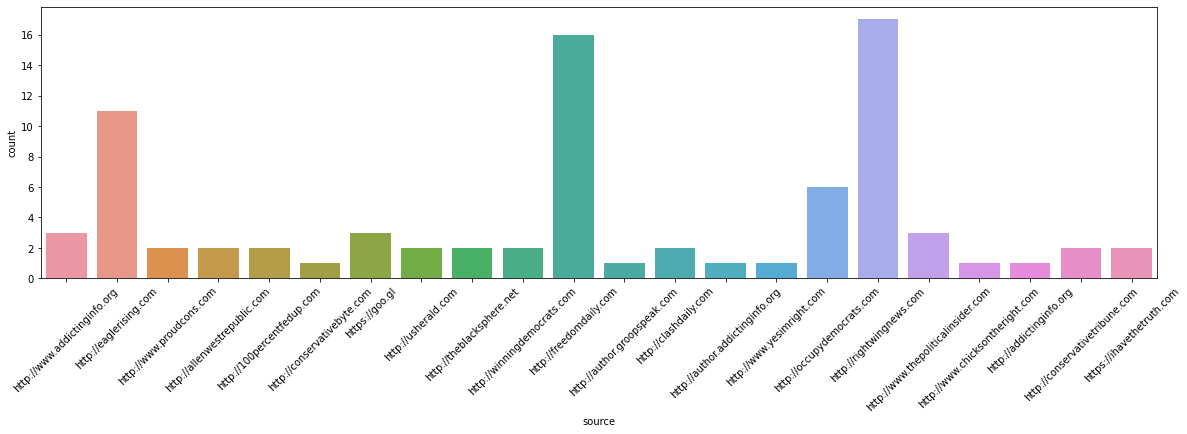

In [16]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bffake)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

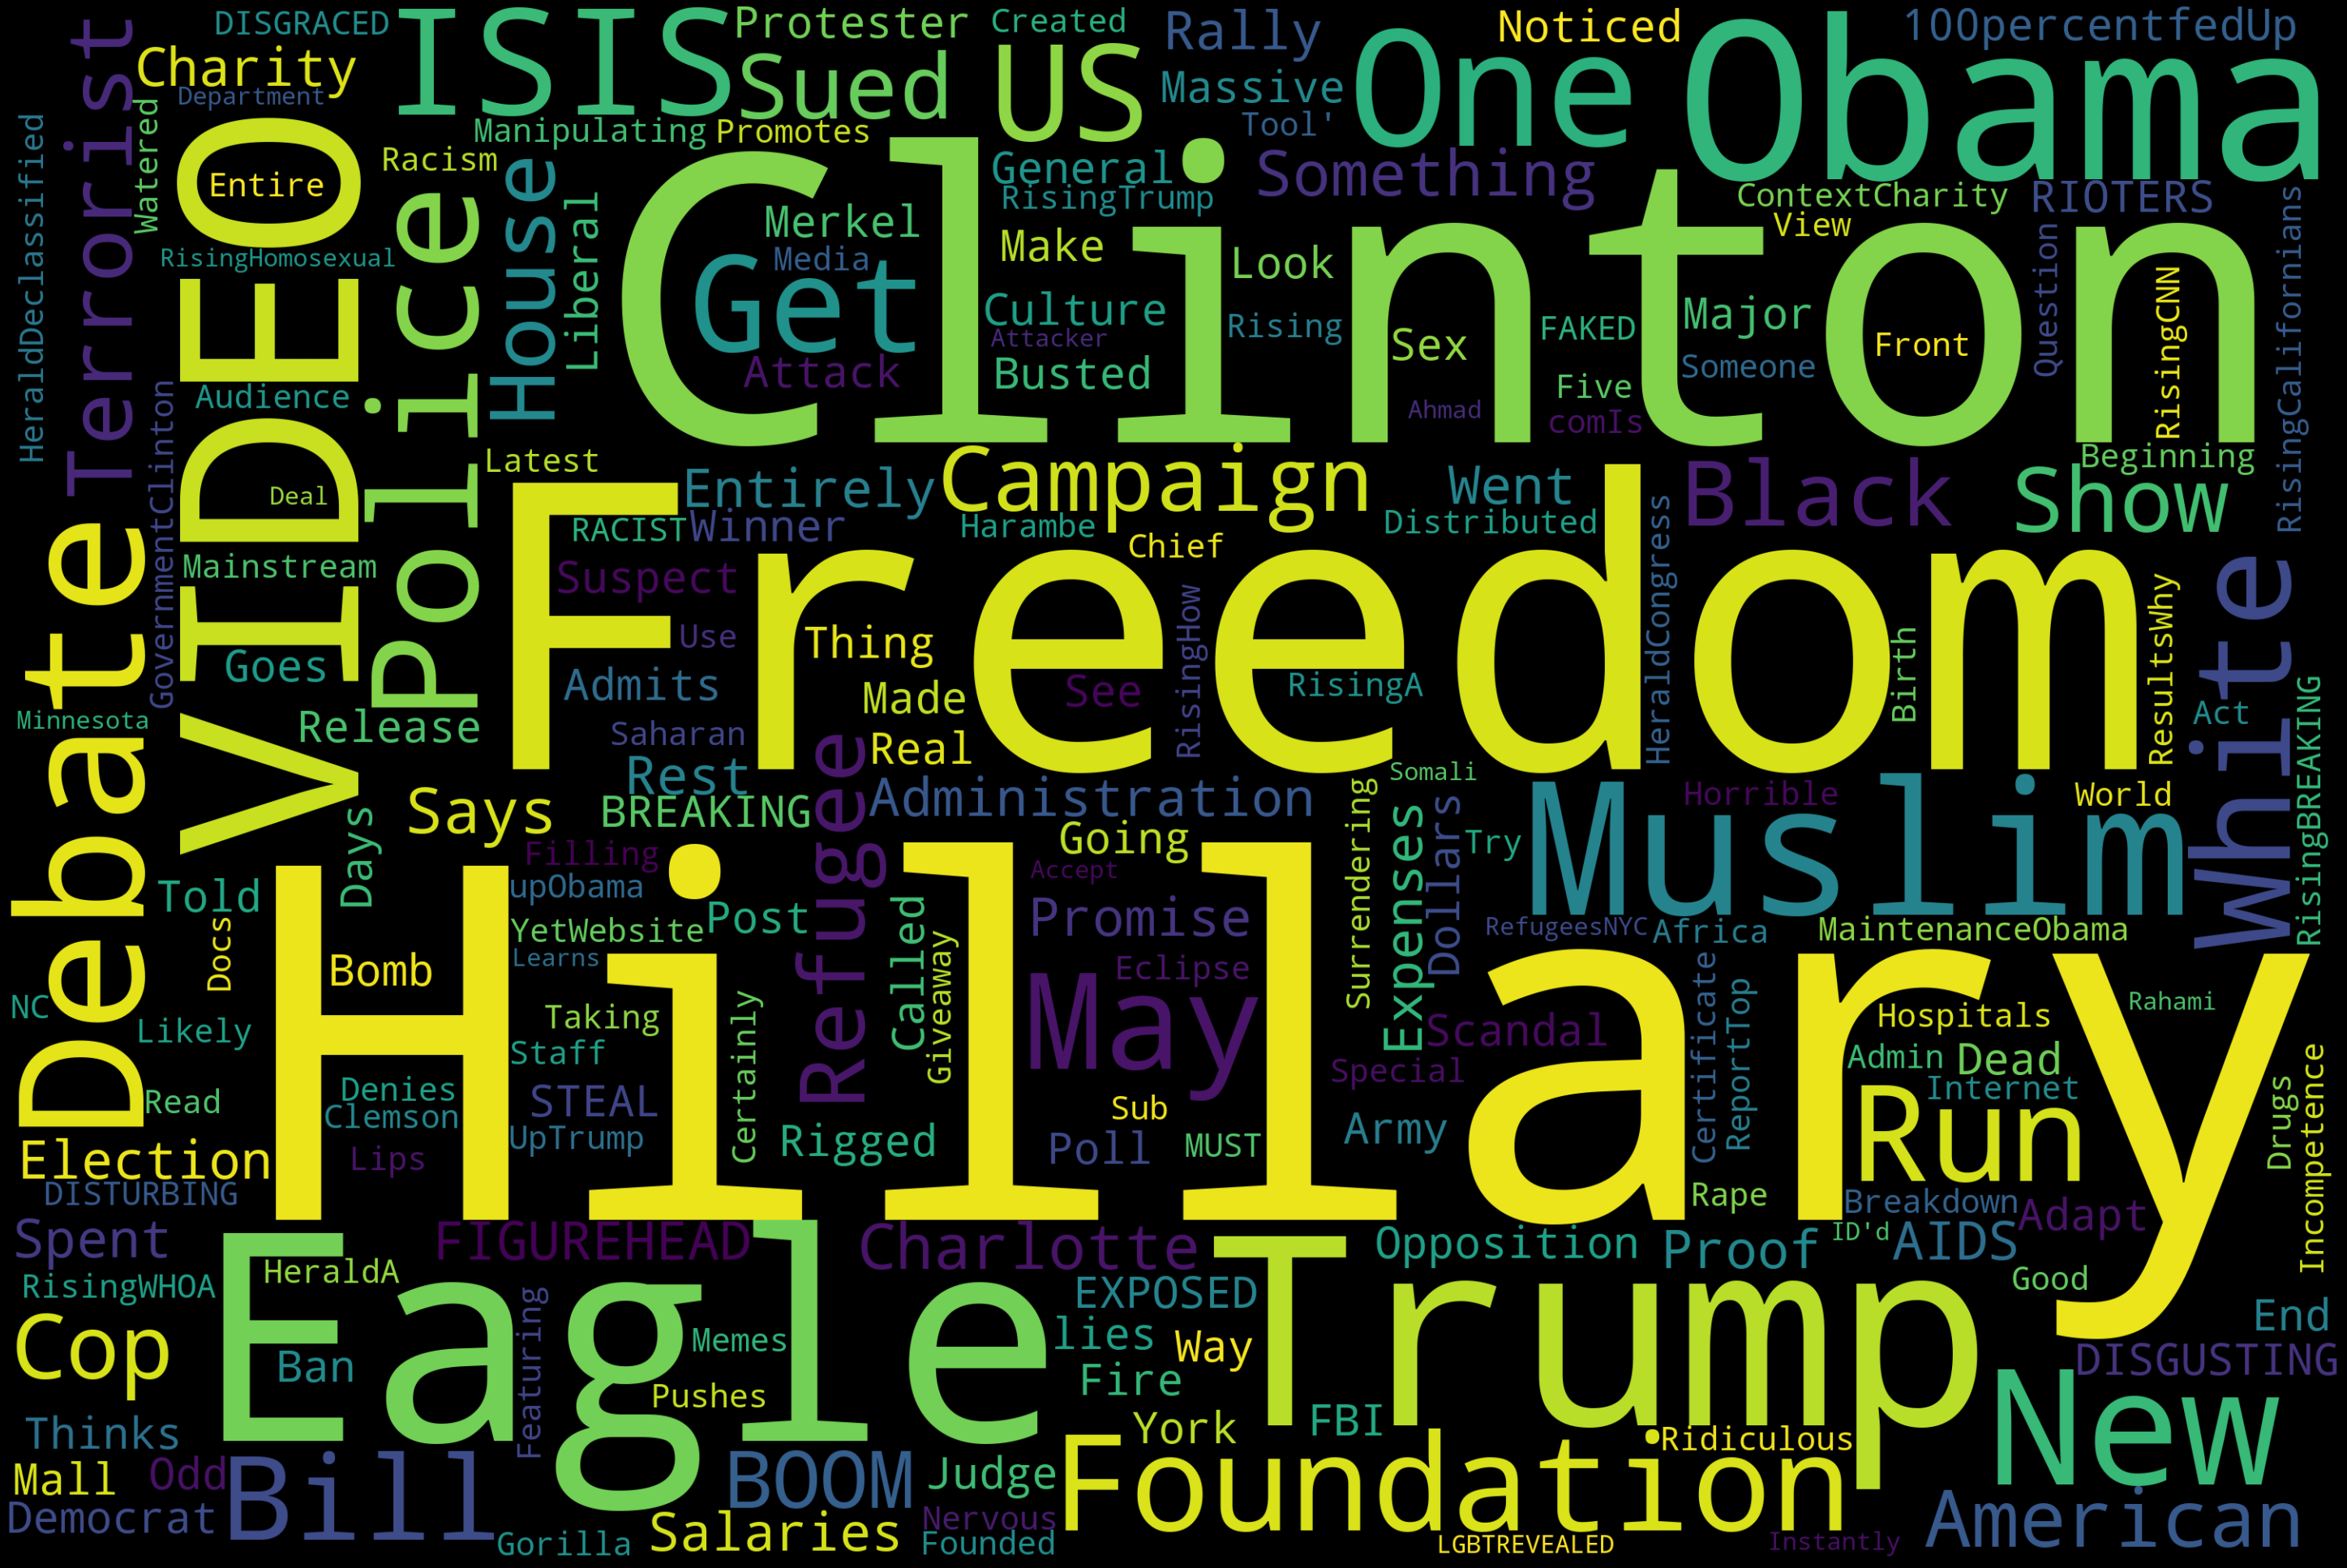

In [17]:
#Word Cloud
text = ''
for news in bffake.title.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

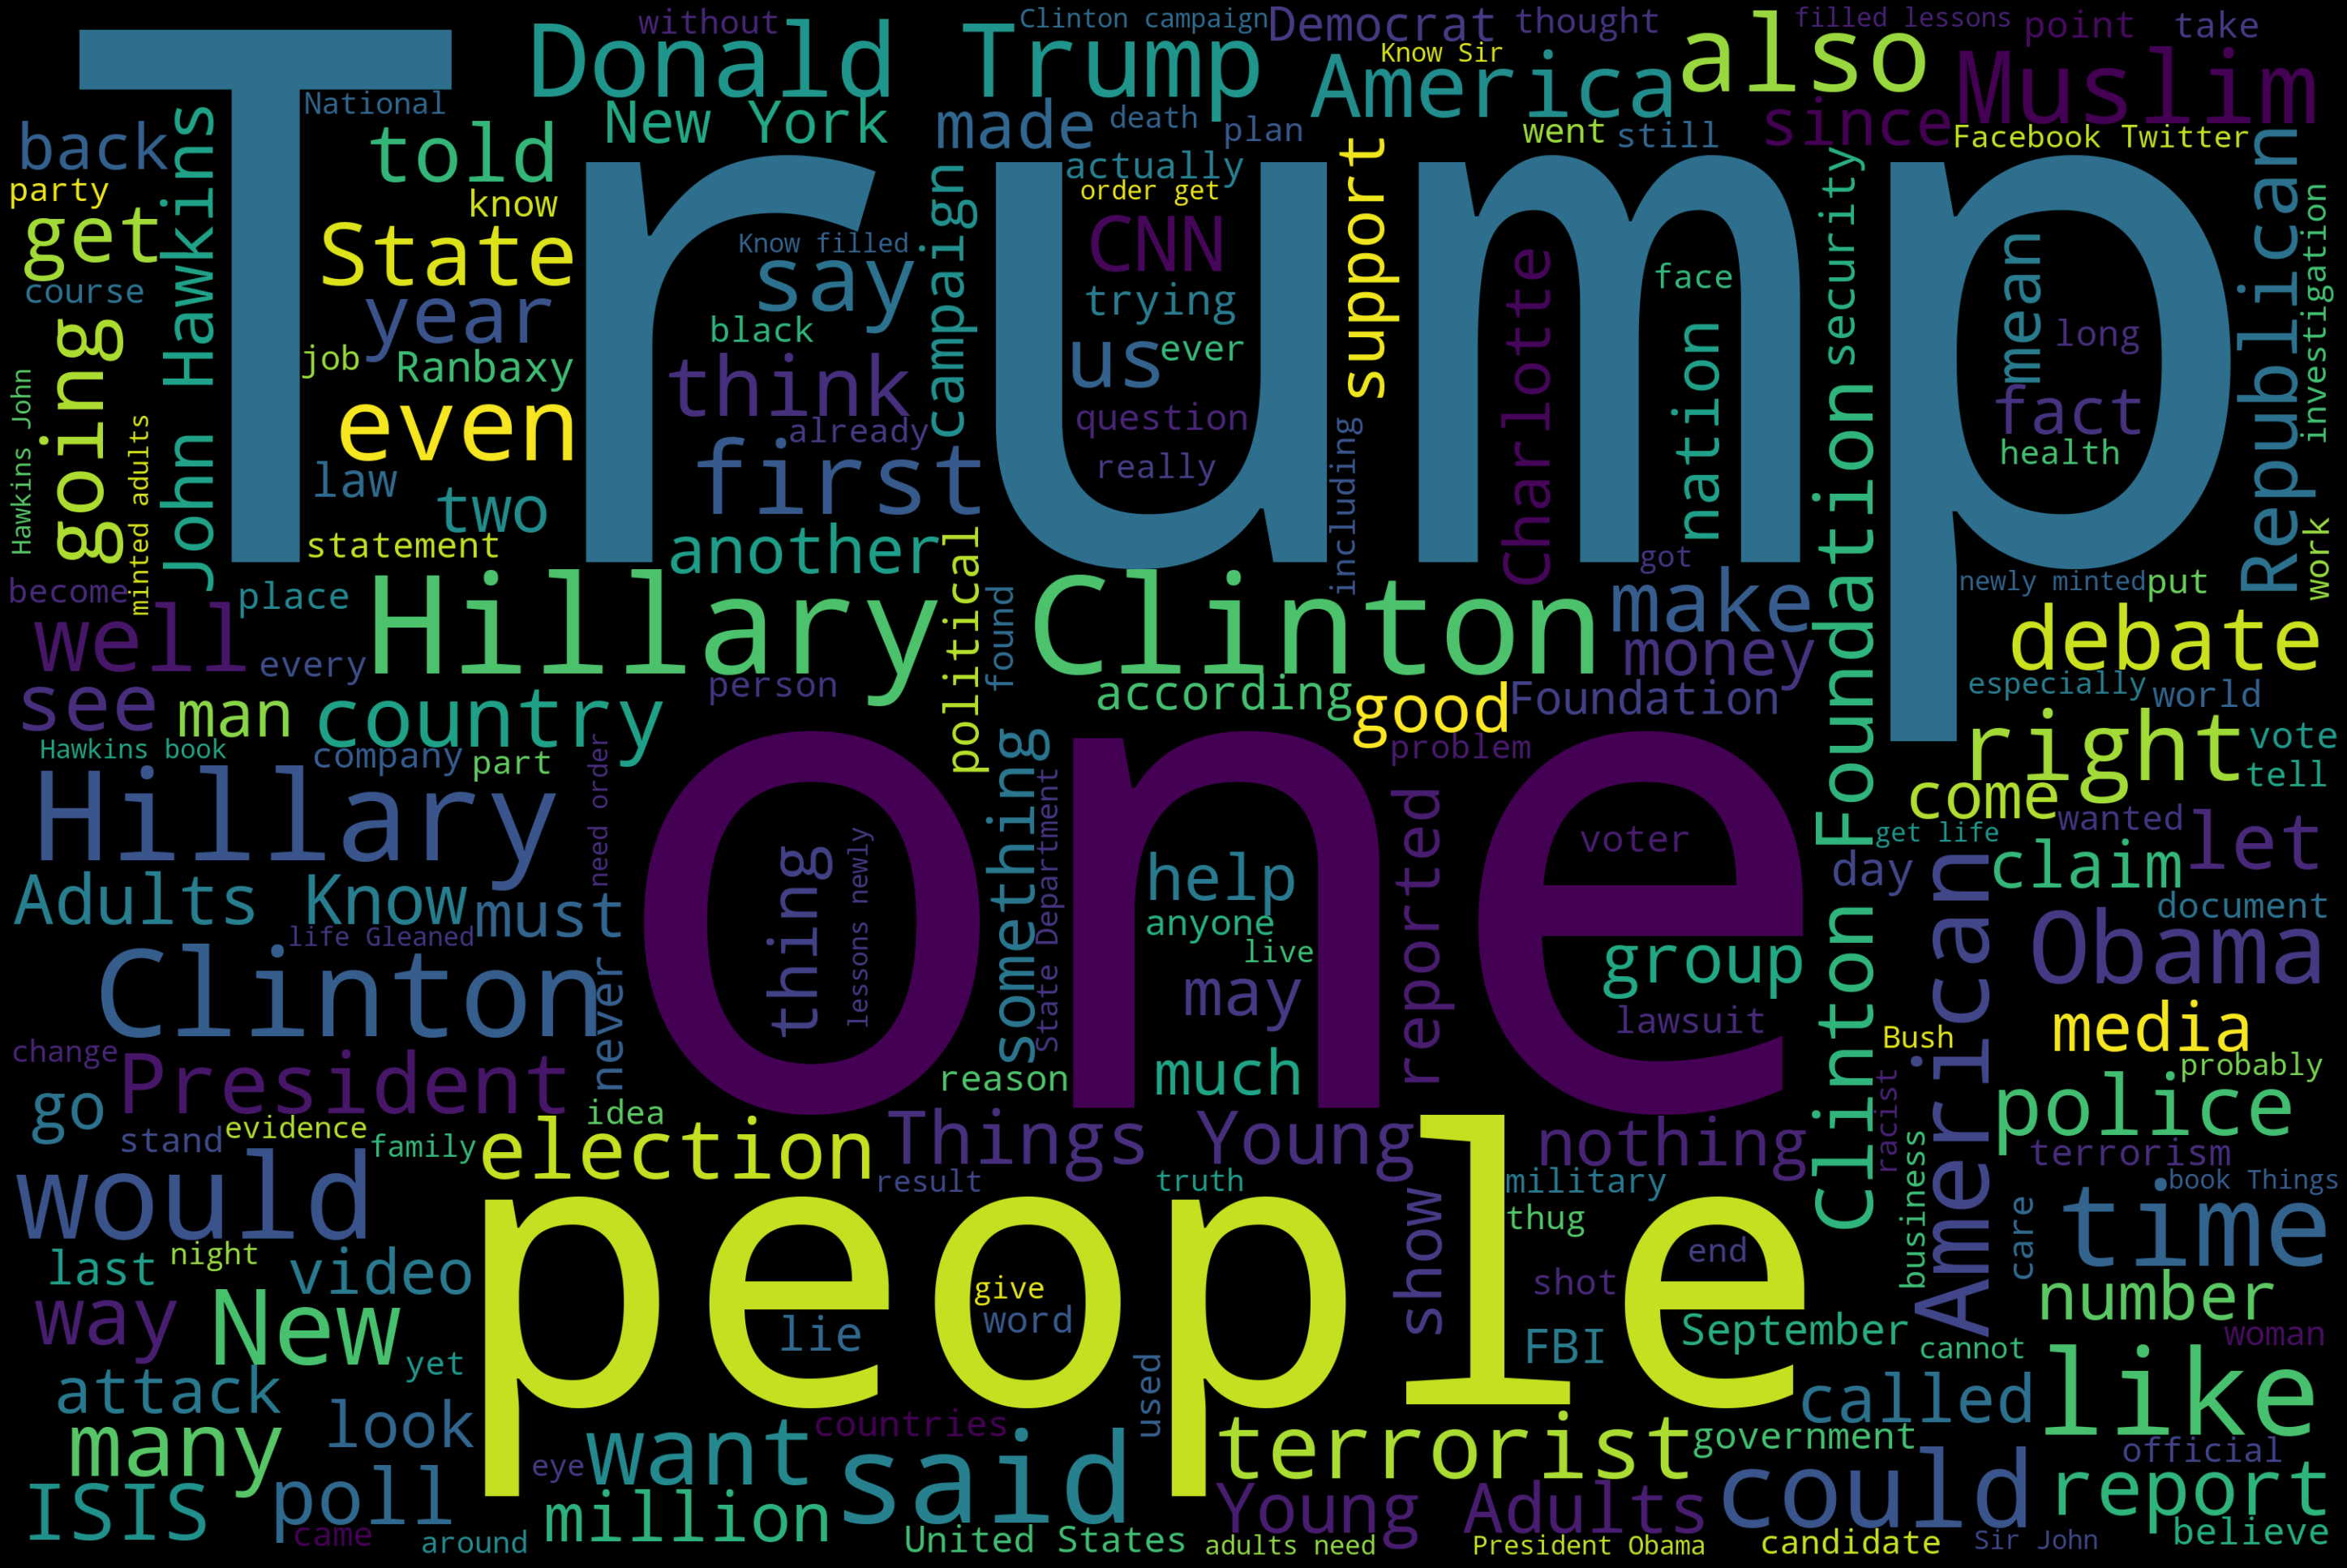

In [18]:
#Word Cloud
text = ''
for news in bffake.text.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [19]:
bffake["class"]=0
bffake["subject"]=''
bffake.head()

id  ... subject
0   Fake_1-Webpage  ...        
1  Fake_10-Webpage  ...        
2  Fake_11-Webpage  ...        
3  Fake_12-Webpage  ...        
4  Fake_13-Webpage  ...        

[5 rows x 14 columns]

Removing all polluting expressions in both text and title

In [0]:
pollution_fake = ["⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_fake:
    bffake['title'] = bffake['title'].str.replace(i , '')
    bffake['text'] = bffake['text'].str.replace(i , '')

### **Analyzing Fake-and-real-news Real News Content** 

In [21]:
reald = pd.read_csv('/content/drive/My Drive/CS221_Project/True.csv')
reald.shape

(21417, 4)

In [22]:
reald.head()

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 

[5 rows x 4 columns]

In [23]:
for key,count in reald.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(reald.shape[0]))

politicsNews:	11272
worldnews:	10145
Total Records:	21417


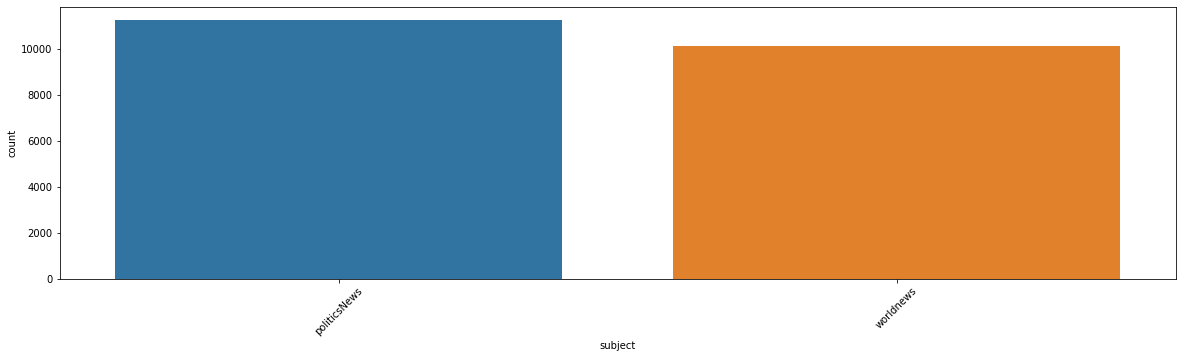

In [24]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=reald)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [25]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(reald.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of publication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)
#Thus we have list of indices where publisher is not mentioned
#lets check
reald.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [26]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for idx,row in enumerate(reald.text.values):
    if idx in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

#Replace existing text column with new text
#add seperate column for publication info in case we want to use it later
reald["source"] = publisher
reald["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers
reald.head()

title  ...                        source
0  As U.S. budget fight looms, Republicans flip t...  ...          WASHINGTON (Reuters)
1  U.S. military to accept transgender recruits o...  ...          WASHINGTON (Reuters)
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...          WASHINGTON (Reuters)
3  FBI Russia probe helped by Australian diplomat...  ...          WASHINGTON (Reuters)
4  Trump wants Postal Service to charge 'much mor...  ...  SEATTLE/WASHINGTON (Reuters)

[5 rows x 5 columns]

In [27]:
#checking for rows with empty text
[index for index,text in enumerate(reald.text.values) if str(text).strip() == '']

[8970]

In [0]:
#dropping this record
reald = reald.drop(8970, axis=0)

In [29]:
#renaming date column before merging with FakenewsNet dataset, and adding a class column
reald["class"]=1
reald = reald.rename(columns={"date":"publish_date"})
reald.head()

title  ... class
0  As U.S. budget fight looms, Republicans flip t...  ...     1
1  U.S. military to accept transgender recruits o...  ...     1
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...     1
3  FBI Russia probe helped by Australian diplomat...  ...     1
4  Trump wants Postal Service to charge 'much mor...  ...     1

[5 rows x 6 columns]

### **Analyzing Fake-and-real-news Fake News Content** 

In [30]:
faked = pd.read_csv('/content/drive/My Drive/CS221_Project/Fake.csv')
faked.shape

(23481, 4)

In [31]:
faked.head()

title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4   Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017

[5 rows x 4 columns]

In [32]:
for key,count in faked.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(faked.shape[0]))

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


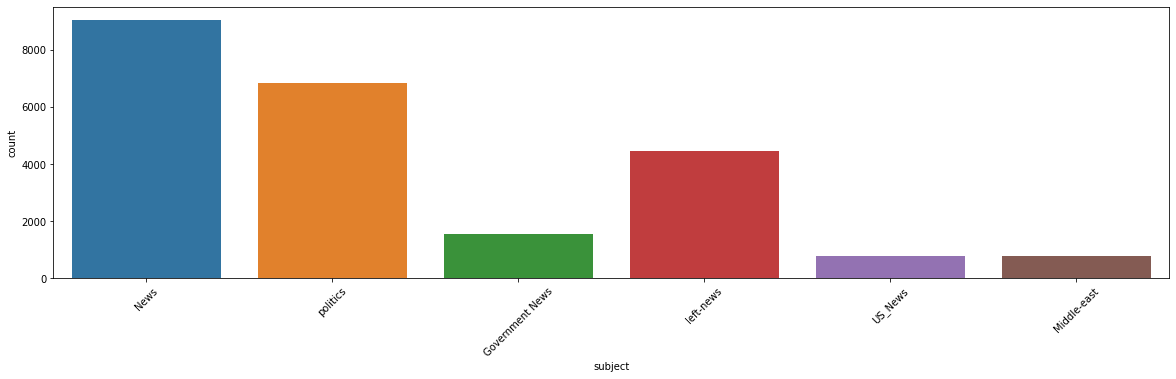

In [33]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=faked)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [34]:
#checking for rows with empty text
empty_faked_index = [index for index,text in enumerate(faked.text.values) if str(text).strip() == '']
print("No of empty rows: {}".format(len(empty_faked_index)))
faked.iloc[empty_faked_index].tail()

No of empty rows: 630


title  ...          date
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...  ...  Apr 27, 2015
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...  ...  Apr 25, 2015
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...  ...  Apr 25, 2015
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...  ...  Apr 14, 2015
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...  ...  Apr 12, 2015

[5 rows x 4 columns]

In [35]:
#dropping this record
for i in empty_faked_index:
  faked = faked.drop(i, axis=0)

faked.shape

(22851, 4)

Removing polluting expressions in both title and text columns

In [0]:
pollution_faked = ["(VIDEO)", "Photo by", "/Getty Images", "Featured image", "pic.twitter.com"]
for i in pollution_faked:
    faked['title'] = faked['title'].str.replace(i , '')
    faked['text'] = faked['text'].str.replace(i , '')

In [107]:
#renaming date column before merging with FakenewsNet dataset, adding a class column and a source one set to "Unknown"
faked["class"]=0
faked["source"]="Unknown"
faked = faked.rename(columns={"date":"publish_date"})
faked.head()

title  ...   source
0   Donald Trump Sends Out Embarrassing New Year’...  ...  Unknown
1   Drunk Bragging Trump Staffer Started Russian ...  ...  Unknown
2   Sheriff David Clarke Becomes An Internet Joke...  ...  Unknown
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  Unknown
4   Pope Francis Just Called Out Donald Trump Dur...  ...  Unknown

[5 rows x 6 columns]

### **Merging all 4 datasets into one** 

**Baseline**: merge title and text, and keep only the resulting value along with the class

In [108]:
bfreal_short = bfreal[["title", "text","class"]]
bfreal_short.head()

title  ... class
0  Another Terrorist Attack in NYC…Why Are we STI...  ...     1
1  Donald Trump: Drugs a 'Very, Very Big Factor' ...  ...     1
2  Obama To UN: ‘Giving Up Liberty, Enhances Secu...  ...     1
3  Trump vs. Clinton: A Fundamental Clash over Ho...  ...     1
4  President Obama Vetoes 9/11 Victims Bill, Sett...  ...     1

[5 rows x 3 columns]

In [109]:
bffake_short = bffake[["title", "text","class"]]
bffake_short.head()

title  ... class
0  Proof The Mainstream Media Is Manipulating The...  ...     0
1  Charity: Clinton Foundation Distributed “Water...  ...     0
2  A Hillary Clinton Administration May be Entire...  ...     0
3  Trump’s Latest Campaign Promise May Be His Mos...  ...     0
4                    Website is Down For Maintenance  ...     0

[5 rows x 3 columns]

In [110]:
reald_short = reald[["title", "text","class"]]
reald_short.head()

title  ... class
0  As U.S. budget fight looms, Republicans flip t...  ...     1
1  U.S. military to accept transgender recruits o...  ...     1
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...     1
3  FBI Russia probe helped by Australian diplomat...  ...     1
4  Trump wants Postal Service to charge 'much mor...  ...     1

[5 rows x 3 columns]

In [111]:
faked_short = faked[["title", "text","class"]]
faked_short.tail()

title  ... class
23476  McPain: John McCain Furious That Iran Treated ...  ...     0
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  ...     0
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  ...     0
23479  How to Blow $700 Million: Al Jazeera America F...  ...     0
23480  10 U.S. Navy Sailors Held by Iranian Military ...  ...     0

[5 rows x 3 columns]

In [112]:
dataset = bfreal_short.append([bffake_short, reald_short, faked_short], ignore_index=True)
dataset.shape

(44449, 3)

In [113]:
#Combining Title and Text
dataset["text"] = dataset["title"] + " " + dataset["text"]
dataset = dataset.drop(["title"], axis=1)
dataset.head()

text  class
0  Another Terrorist Attack in NYC…Why Are we STI...      1
1  Donald Trump: Drugs a 'Very, Very Big Factor' ...      1
2  Obama To UN: ‘Giving Up Liberty, Enhances Secu...      1
3  Trump vs. Clinton: A Fundamental Clash over Ho...      1
4  President Obama Vetoes 9/11 Victims Bill, Sett...      1

In [114]:
dataset.tail()

text  class
44444  McPain: John McCain Furious That Iran Treated ...      0
44445  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...      0
44446  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...      0
44447  How to Blow $700 Million: Al Jazeera America F...      0
44448  10 U.S. Navy Sailors Held by Iranian Military ...      0

In [115]:
dataset.count()

text     44449
class    44449
dtype: int64

In [116]:
dataset["class"].value_counts()

0    22942
1    21507
Name: class, dtype: int64

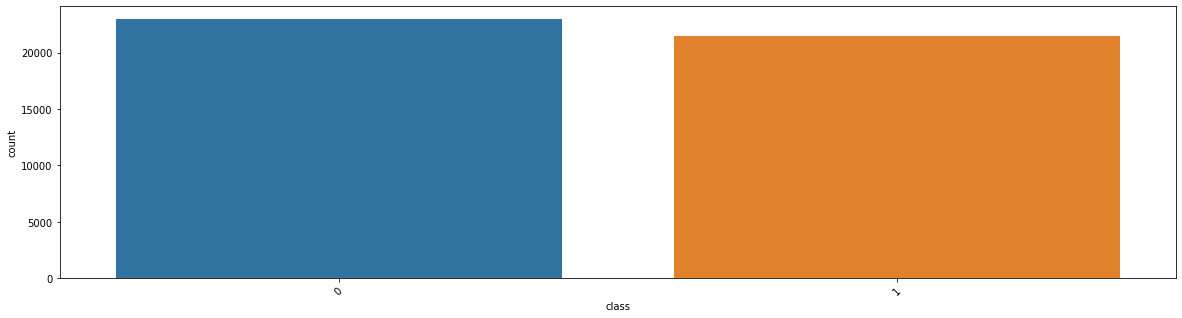

In [117]:
plt.figure(figsize=(20,5))
chart = sns.countplot("class", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

**Alternative**: keep 5 columns? leverage subject on top of title+text?

## **Tokenization, analyze of text structure, word occurence and repetition**

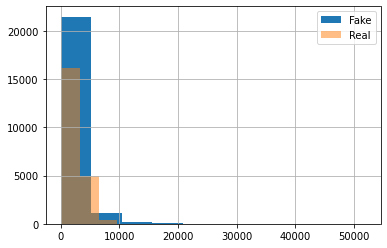

In [118]:
dataset_real = dataset.loc[dataset['class'] == 1]
dataset_fake = dataset.loc[dataset['class'] == 0]
dataset_fake['text'].str.len().hist()
dataset_real['text'].str.len().hist(alpha=0.5)
plt.legend(['Fake', 'Real'])

Some fake news had lots of upper case, which may generate a strong bias in detection since they can be easily used in real news as well. 
So tokenizing sentences, passing all text to lower case, removing stop words, punctuation and single-character words

In [0]:
y = []
y = dataset["class"].values
#Converting X to format acceptable by gensim, removing stopwords and punctuation in the process
stop_words = set(nltk.corpus.stopwords.words("english"))
X = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in dataset["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

#del dataset

In [148]:
X[0][:10]

['another',
 'terrorist',
 'attack',
 'nyc',
 'still',
 'politically',
 'correct',
 'saturday',
 'september',
 '17']

In [149]:
len(X)

44449

In [150]:
#Identifying indexes of real and fake news
real_idx = [i for i,v in enumerate(y) if v == 1]
fake_idx = [i for i,v in enumerate(y) if v == 0]
print(len(real_idx), len(fake_idx))

21507 22942


In [151]:
X_real = []
X_fake = []
X_real = [X[i] for i in real_idx]
X_fake = [X[j] for j in fake_idx]
print(len(X_real), len(X_fake))

21507 22942


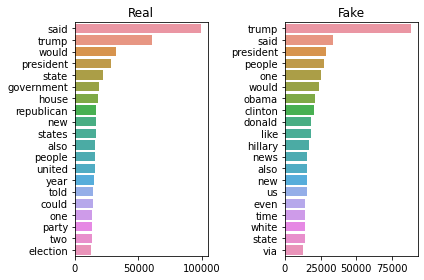

In [146]:
#Let's analyze most frequent words
corpus_real=[word for i in X_real for word in i]
counter_real=Counter(corpus_real)
most_real=counter_real.most_common()

x1, x2= [], []
for word,count in most_real[:40]:
    if (word not in stop_words and len(word) > 1):
        x1.append(word)
        x2.append(count)
 
corpus_fake=[word for j in X_fake for word in j]
counter_fake=Counter(corpus_fake)
most_fake=counter_fake.most_common()

x3, x4= [], []
for word,count in most_fake[:40]:
    if (word not in stop_words and len(word) > 1):
        x3.append(word)
        x4.append(count)

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=x2[:20],y=x1[:20],ax=ax1).set_title('Real')
sns.barplot(x=x4[:20],y=x3[:20],ax=ax2).set_title('Fake')
fig.tight_layout()

 bigrams and trigrams in both classes

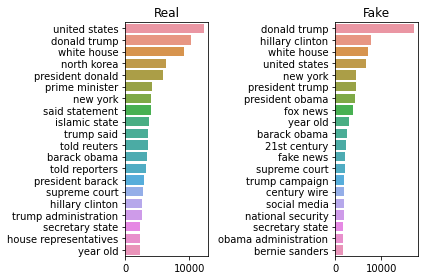

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

top_n_bigrams_real=get_top_ngram(dataset_real['text'],2)[:20]
x_,y_=map(list,zip(*top_n_bigrams_real))
top_n_bigrams_fake=get_top_ngram(dataset_fake['text'],2)[:20]
w_,z_=map(list,zip(*top_n_bigrams_fake))

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=y_,y=x_,ax=ax1).set_title('Real')
sns.barplot(x=z_,y=w_,ax=ax2).set_title('Fake')
fig.tight_layout()

TF-IDF, k-means (to be continued)

In [152]:
#Alternative method of analzing ngrams via TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
class NewTfidfVectorizer(TfidfVectorizer):
    def _word_ngrams(self, tokens, stop_words=None):

        # First get tokens without stop words
        tokens = super(TfidfVectorizer, self)._word_ngrams(tokens, None)
        if stop_words is not None:
            new_tokens=[]
            for token in tokens:
                split_words = token.split(' ')

                # Only check the first and last word for stop words
                if split_words[0] not in stop_words and split_words[-1] not in stop_words:
                    new_tokens.append(token)
            return new_tokens

        return tokens

vectorizer = NewTfidfVectorizer(stop_words='english', ngram_range=(3,3))
vectorizer.fit(dataset["text"])

NewTfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0,
                   max_features=None, min_df=1, ngram_range=(3, 3), norm='l2',
                   preprocessor=None, smooth_idf=True, stop_words='english',
                   strip_accents=None, sublinear_tf=False,
                   token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
                   use_idf=True, vocabulary=None)

Topic Modeling exploration with pyLDAvis

In [0]:
#Tokenization and lemmatization
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['text']:
        words=[w for w in nltk.word_tokenize(news) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(dataset)

In [0]:
#Let’s create the bag of words model using gensim
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [100]:
#And finally create the LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.008*"The" + 0.007*"Clinton" + 0.005*"Trump" + 0.005*"said" + 0.005*"would" + 0.004*"Obama" + 0.004*"state" + 0.004*"Republican" + 0.004*"Hillary" + 0.004*"law"'),
 (1,
  '0.016*"said" + 0.014*"Trump" + 0.010*"The" + 0.009*"U.S." + 0.006*"Russia" + 0.005*"President" + 0.005*"United" + 0.005*"official" + 0.005*"Russian" + 0.004*"would"'),
 (2,
  '0.015*"said" + 0.012*"The" + 0.007*"would" + 0.006*"government" + 0.006*"year" + 0.005*"percent" + 0.004*"U.S." + 0.004*"country" + 0.004*"state" + 0.004*"tax"'),
 (3,
  '0.016*"Trump" + 0.007*"The" + 0.006*"people" + 0.004*"one" + 0.004*"said" + 0.004*"like" + 0.004*"Donald" + 0.003*"say" + 0.003*"police" + 0.003*"know"')]

In [0]:
%%capture
!pip install pyLDAvis

In [102]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.154751  0.017351       1        1  30.958393
0      0.057236 -0.042996       2        1  24.467669
2     -0.117226 -0.098195       3        1  22.525043
1     -0.094760  0.123840       4        1  22.048897, topic_info=          Term           Freq          Total Category  logprob  loglift
257       said  105468.000000  105468.000000  Default  30.0000  30.0000
1135      U.S.   36637.000000   36637.000000  Default  29.0000  29.0000
2889    Russia   14022.000000   14022.000000  Default  28.0000  28.0000
72       Trump  111641.000000  111641.000000  Default  27.0000  27.0000
3337   Russian   11123.000000   11123.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
2137      told    7250.119141   21172.783203   Topic4  -5.8174   0.4402
580      Obama    7552.991211   30137.792969   Topic4  -5.7765   0.1281
119    country    7225.860352   24520.644531   Topic4  -5.8207   0.2901
1497  campaign    6658.704102   19131.626953   Topic4  -5.9025   0.4565
258        say    6289.446289   27004.136719   Topic4  -5.9595   0.0548

[409 rows x 6 columns], token_table=        Topic      Freq   Term
term                          
12770       3  0.998667   2019
12604       2  0.997289   ACLU
242270      1  0.994316    ACR
242270      2  0.004633    ACR
68107       3  0.998915    ANC
...       ...       ...    ...
556         4  0.216040  would
313         1  0.198661   year
313         2  0.216218   year
313         3  0.439231   year
313         4  0.145898   year

[876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

## **Vectorization via Word2Vec**

In [0]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [154]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 122681 words by a 100dim vector.

122607

In [155]:
#see a sample vector for random word 
w2v_model["clinton"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 1.3265015e+00,  4.8791888e-01, -1.2581559e-01, -1.4970738e+00,
        6.8183674e-04,  8.2923832e+00,  1.3142815e+00,  1.6787677e+00,
       -1.7649614e+00, -9.5444226e-01, -1.7249414e+00, -2.6828604e+00,
       -4.3729699e-01, -3.1906600e+00,  4.9346175e+00, -1.0460505e+00,
        2.9770866e-01, -2.1381159e+00,  1.5837704e+00, -9.7257990e-01,
        1.7820497e+00,  2.1917298e+00, -1.1995876e+00,  3.3085861e+00,
       -7.5210166e-01,  2.8254545e-01,  3.6900375e+00, -2.4240632e+00,
        1.2491806e+00, -6.0230237e-01,  2.2641830e+00,  1.0372959e-01,
        4.4958174e-01,  1.4182955e+00, -1.8506253e+00, -5.1710801e+00,
        7.2169214e-01,  2.8444371e+00, -1.3796514e-01,  4.5446830e+00,
       -2.1556766e+00,  3.0397310e+00,  7.5210983e-01,  6.5489537e-01,
        3.6872725e+00, -2.3151693e+00, -6.3160310e+00, -9.1218239e-01,
       -4.7838673e-01,  1.3638517e+00,  8.6149442e-01,  7.2210199e-01,
        1.2041092e+00, -4.6745700e-01, -9.7475958e-01,  1.8983723e+00,
      

In [156]:
w2v_model.wv.most_similar("freedom")

[('freedoms', 0.6514476537704468),
 ('liberty', 0.6283401250839233),
 ('free', 0.5843701362609863),
 ('expression', 0.5677374601364136),
 ('democracy', 0.5203269720077515),
 ('clobbering', 0.488751083612442),
 ('nonobjective', 0.4854140877723694),
 ('collective', 0.47043484449386597),
 ('navigation', 0.4692976474761963),
 ('exercising', 0.4645356237888336)]

In [157]:
w2v_model.wv.most_similar("people")

[('folks', 0.7255774140357971),
 ('americans', 0.68161541223526),
 ('citizens', 0.6483410596847534),
 ('blacks', 0.5993427634239197),
 ('adults', 0.5918282866477966),
 ('men', 0.5831971168518066),
 ('voters', 0.5831624269485474),
 ('person', 0.5757330656051636),
 ('others', 0.5754351615905762),
 ('ones', 0.5724660754203796)]

In [0]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of original word to number is preserved in word_index property of tokenizer

#Tokenizer applies basic processing like changing it to lower case, explicitely setting that as True

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [159]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[105, 638, 165, 3908, 102, 1678, 1867, 409, 524, 890]

In [160]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


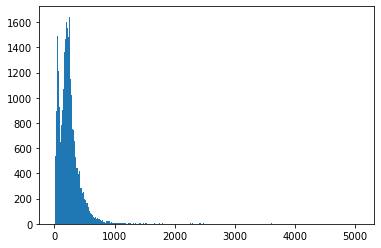

In [161]:
# Making histogram for no of words in news shows that most news article are under 700 words.
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [162]:
# Lets keep each news small and truncate all news to 700 while tokenizing
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43524

In [0]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above, padding with 0 when needed
X = pad_sequences(X, maxlen=maxlen)

In [164]:
#Checking
len(X[0])

700

In [0]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [0]:
# Function to create weight matrix between word-index and vectors from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

## **Modelization** 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

Naïve Bayes model

In [0]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_model = MultinomialNB().fit(X_train,y_train)

In [174]:
#Model Evaluation
predictions = naive_bayes_model.predict(X_test)
print(predictions)

[1 1 0 ... 1 1 0]


In [175]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.74      0.66      5747
           1       0.63      0.47      0.54      5366

    accuracy                           0.61     11113
   macro avg       0.61      0.60      0.60     11113
weighted avg       0.61      0.61      0.60     11113



Many to one LSTM

In [0]:
#Getting embedding vectors from word2vec and using it as weights of non-trainable keras embedding layer
#This embedding layer accepts numerical-token of word and outputs corresponding vector to inner layer.
#It sends vector of zeros to next layer for unknown words which would be tokenized to 0.
#Input length of embedding Layer is the length of each news (700 now due to padding and truncating)
%%capture
del embedding_vectors
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [0]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

#del embedding_vectors

In [182]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 100)          12260800  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 12,378,177
Trainable params: 117,377
Non-trainable params: 12,260,800
_________________________________________________________________


In [183]:
lstm_model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
730/730 [==============================] - 514s 704ms/step - loss: 0.1342 - acc: 0.9509 - val_loss: 0.1117 - val_acc: 0.9624
Epoch 2/6
730/730 [==============================] - 513s 702ms/step - loss: 0.0763 - acc: 0.9740 - val_loss: 0.0758 - val_acc: 0.9740
Epoch 3/6
730/730 [==============================] - 516s 707ms/step - loss: 0.0502 - acc: 0.9833 - val_loss: 0.0396 - val_acc: 0.9881
Epoch 4/6
730/730 [==============================] - 513s 702ms/step - loss: 0.0306 - acc: 0.9900 - val_loss: 0.0478 - val_acc: 0.9820
Epoch 5/6
730/730 [==============================] - 517s 708ms/step - loss: 0.0276 - acc: 0.9916 - val_loss: 0.0517 - val_acc: 0.9823
Epoch 6/6
730/730 [==============================] - 510s 698ms/step - loss: 0.0156 - acc: 0.9952 - val_loss: 0.0338 - val_acc: 0.9901


In [0]:
#Prediction is in probability of news being real, so converting into classes
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [185]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.73      0.66      5747
           1       0.63      0.51      0.57      5366

    accuracy                           0.62     11113
   macro avg       0.62      0.62      0.62     11113
weighted avg       0.62      0.62      0.62     11113

